# Machine, Data and Learning
## Assignment 3 - Genetic Algorithm

## Team 43

**Vasu Singhal (2018101074)**

**Tanish Lad (2018114005)**

## Summary of our Genetic Algorithm

Importing the required modules and the client_moodle file

In [7]:
from client_moodle import *
import random
import json

k represents the population size. We initially tried k = 4 but that turned out to be inefficient due to less randomness during crossover. Ideally, we would have loved to choose k = 16, but due to availability of less number of requests per day, we settled for k = 10.

In [8]:
k = 10

Initially, we were not sure how many generations will the algorithm take to converge. We experimented with a large number of values wherein we saw different kinds of results, but, we observed that letting the algorithm run for 200 generations proved to be good to see noteworthy improvement.

In [9]:
num_generations = 200

This is our team's secret key. Our team number is **43**.

In [10]:
secret_key = 'se1Poy6HllKuLEK3WlsQnfi6qAN6zt5JqbUgbchBylLc0FmRf2'

This is our fitness function. Explained in detailed later in the report.

In [11]:
def fitness_fn(training_error, validation_error):
    fitness = 1 / ((training_error + validation_error) + 2 * abs(training_error - validation_error))

    return fitness

Loading the best coefficients we had got from the previous run of the code. If there were less than 10 (k = 10) stored, we filled the remaining vectors with the best vector (which gave the greatest fitness). In the end, state is a list containing of 'k' vectors. It represents the population in the context of Genetic Algorithm. For the first run of the code, initial_coefficients was the overfit vector given to us. The initial population was the overfit vector repeated k times.

In [12]:
initial_coefficients = json.load(open("coefficients.txt"))
init = []

max_fitness = -1e12
best_coeff = []
errors = []

ratio = 1

for i in initial_coefficients:
    if max_fitness < float(fitness_fn(initial_coefficients[i][0], initial_coefficients[i][1])):
        max_fitness = float(fitness_fn(initial_coefficients[i][0], initial_coefficients[i][1]))

        best_coeff = i.strip('][').split(', ')
        both_errors = (initial_coefficients[i][0], initial_coefficients[i][1])

    init.append(list(map(float, i.strip('][').split(', '))))

    errors.append((float(fitness_fn(initial_coefficients[i][0], initial_coefficients[i][1])), list(map(
        float, i.strip('][').split(', '))), (initial_coefficients[i][0], initial_coefficients[i][1])))

while len(init) < k:
    init.append(list(map(float, best_coeff)))
    errors.append((max_fitness, list(map(float, best_coeff)), both_errors))

err = [[1, 1] for j in range(k)]

state = [init[j] for j in range(k)]

# print(errors)

This was just a dummy function to check if our code did not give any compilation or runtime errors after we make some changes in the code. This replaced the get_errors function in the client_moodle file. This was done to prevent loss of requests (because requests were limited).

In [13]:
# def get_errors(id, vector):
#     return [1, 10000]

This is our mutation function. Explained in detailed later in the report.

In [14]:
def mutate(child):
    no_of_mutation = random.randint(1, 3)

    for i in range(no_of_mutation):
        index = random.randint(0, 10)

        new_val = random.uniform(-10, 10)
        new_val /= 100
        new_val *= child[index]

        child[index] += new_val
        child[index] = max(child[index], -10)
        child[index] = min(child[index], 10)

    return child

This is our crossover function. Explained in detailed later in the report.

In [15]:
def crossover(child1, child2):
    
    crossover_point = random.randint(0, 10)
    a = child1[:crossover_point] + child2[crossover_point:]
    b = child2[:crossover_point] + child1[crossover_point:]

    return a, b

This function stores the best individuals which are later stored in a file. In the next run of the code, these individuals will comprise the initial populalation.

In [16]:
def store_best(fitness, err, errors):
    new_errors = errors

    for j in range(k):
        tup = (fitness[j], state[j], (err[j][0], err[j][1]))
        new_errors.append(tup)
    new_errors.sort(reverse=True)

    errors = [new_errors[j] for j in range(k)]

    return errors

This function assigns weights to individuals proportional to their fitness, so that the individuals that have better fitness have better chance to be selected in the next population.

In [17]:
def get_weights(fitness):
    const = 100 / sum(fitness)
    perc = [(const * fitness[j]) for j in range(k)]

    return perc

This function selects the new population from the old population randomly based on their weights.

In [18]:
def select_new_population(old_population, weights, population_size):
    return random.choices(old_population, weights, k=population_size)

This function helps in the crossover and mutation of the new population.

In [19]:
def crossover_and_mutate(population):
    for j in range(k // 2):
        population[2 * j], population[2 * j + 1] = crossover(population[2 * j], population[2 * j + 1])

        population[2 * j] = mutate(population[2 * j])
        population[2 * j + 1] = mutate(population[2 * j + 1])

    return population

This function is our genetic algorithm. It runs for a fixed number of generations. In each generation, fitness of each of the individual of the population is calculated. Then weights are assigned to each of the individuals based on their fitness, giving more weights to individuals having greater fitness. Then new population is selected from the old one based on these weights. This new population is subjected to crossovers and mutations to get the population for the next generation.

In [23]:
for i in range(num_generations):

    err = [get_errors(secret_key, state[j]) for j in range(k)]
    fitness = [fitness_fn(err[j][0], err[j][1]) for j in range(k)]

    errors = store_best(fitness, err, errors)

    perc = get_weights(fitness)

    new_state = select_new_population(state, perc, k)
    new_state = crossover_and_mutate(new_state)

    state = new_state

The k best individuals are stored in a file for later use.

In [21]:
new_coefficients = {}
for i in range(k):
    new_coefficients[str(errors[i][1])] = [errors[i][2][0], errors[i][2][1]]

json.dump(new_coefficients, open("coefficients.txt", 'w'))

### Major Changes from the Base Genetic Algorithm

1. We completely changed the mutation part which is explained in detailed later in the report
2. We didn't let the algorithm converge, instead letting it run only for a fixed number of generations.

## The Fitness Function

Our fitness function went through a lot of changes.

Initially with the overfit vectors, there was a very large difference between the train error and validation error. The validation being almost 40 times the test error, for the first few days we focussed only on validation error. So our fitness function was initially just the magnitude of the inverse of the validation error. 

As we made several requests, the validation error kept decreasing and training error kept increasing. At around 10,00,000, they became equal. At this point we decided to switch to a fitness function which would take both the errors into account. So we changed the fitness function to be the sum of both errors. Whenever we felt that one error was decreasing much more than the other, we would increase the weightage of the other error in the fitness functions.

At one point, when the sum of both the errors was also pretty small, we tried to reduce just the difference between the two errors. So our fitness function became the magnitude of difference between the two errors, thinking it would lead to more generalized coefficients which would fit better on unseen dataset. We got mixed results. It worked sometimes, but many times the difference between the two errors would reduce to zero but the sum would shoot up really high. Nevertheless we kept switching between sum and difference regularly.

We also tried keeping the fitness function as the product of the two errors, but this did not work too well for us.

For the last few days, we mostly kept the fitness function to be 1/(sum + 2 * abs(diff)) as this seemed to be reducing the sum of errors while making sure that the difference doesn’t shoot up.

Mathematically, these were all the fitness functions that we tried during the course of the assignment:

Let T = Training Error, V = Validation Error

1. 1/V
2. 1/(T + V)
3. 1/(T + 5 * V)
4. 1/(T + 2 * V)
5. 1/(2 * T + V)
6. 1/(5 * T + V)
7. 1/abs(T - V)
8. 1/((T + V) + abs(T - V))
9. **1/((T + V) + 2 * abs(T - V))**
10. 1/((T + V) + 5 * abs(T - V))
11. 1/(T * V)
12. 1/(T * V * V)

## The Crossover Function

For the crossover function, we decided to go with the one point crossover mentioned in the book. After selecting the new population from the previous population(based on their fitness), we split the new population into groups of size two. Then for each group we randomly selected an index(between 0 and 10 inclusive). Suppose the index selected was ‘i’ and the two coefficients of the current group were A and B. We replaced A and B by :-

			A := A[:i] + B[i:]
			B := B[:i] + A[i:]
			simultaneously

## The Mutation Function

The mutation function was unarguably the most important part of our implementation of the Genetic Algorithm. Most of our variations in the coefficients can be traced back to the mutation function. This function went through a lot of changes before we finally settled for a fixed one.

Initially, we were doing what the textbook said: mutate with a very small probability, and to mutate, select a random index and replace the value of the coefficient of that index with a completely random value. But soon, we realised that this is proving to be a lot inefficient and was wasting our requests.

Next, we tried to always mutate - keep the mutation probability to be 1.0. But still, we were not getting results as we had expected. Those were the days when we had only 200 requests per day (Yes, we had started that early :)), so we could not do much in a day.

Then, we thought why was the algorithm not giving us good results. We realised that changing the coefficient directly with a random value was leading to a lot of variation. So what we did then was, instead of replacing the coefficient with a completely random value, we should add/subtract the coefficient with a small value within a range. 

Initially, we thought the range [-2, 2] is sufficiently small to be honest. Later did we realise that it is a very very large range and is creating a lot of ruckus. We then tried the range [-0.01, 0.01]. Even that didn't work very well. We then observed our coefficients. Most of them were in the range of 1e-12s or 1e-13s. So we decided to keep the range very small. We settled on [-1e13, 1e13].

It started to give pretty good results. We were happy. But, then, after some days, we got stuck. Our errors were not decreasing and it got stuck in a local minima. We tried many things, but nothing worked.

We didn't know what to do. But, after some days, we realised something. When we were looking at our coefficients, we saw that there was a coefficient which was a lot greater than 1 and mutating it with a value of a very small range of 1e-13 wouldn't make much of a difference in the error. Then it stuck in our mind to not add/subtract a value from a fixed range. We should add/subtract a value which is proportional to the value of the coefficient. So we initially decided to take [-10%, 10%] of the coefficient as the range. So for a coefficient of range 1e-13, mutation would be in the range of [-1e-14, 1e-14], but for a coefficient which has value, say for example, 5, mutatation would be in the range of [-0.5, 0.5], so that it could make a noteable difference.

This started giving us very good results. We once even got errors around [2 Lakhs, 2 Lakhs] as [Training Error, Validation Error] respectively. We had overfit the data. (And we realised that very late). Whenever we saw that the mutations were giving large variations, we changed the range to [-5%, 5%]. We alternated between [-5%, 5%] and [-10%, 10%] often depending upon the situation.

We also tried increasing the number of mutations. Instead of only 1 mutation each time, we tried increasing the mutations to a random integer from 1 to 6. Sometimes it gave better results, sometimes not.

## The Hyperparameters

1. Pool Size - We initially tried keeping the population size as 4 but that turned out to be inefficient due to less randomness during crossover. Ideally, we would have loved to choose 16 as the population size, but due to availability of less number of requests per day, we settled for 10.

2. Splitting Point for Creating New Genes - The point was chosen randomly. This was done to get some variation. Choosing the same index would have given us not so new vectors, and thus, less variation.

3. Number of generations - Explained later in the report.

## Statistical Information

Number of generations to converge - We never let the algorithm to converge by itself. We let the algorithm run only for a fixed number of iterations each time, that varied. We tried 20, 50, 100, 200, 250, 500. But we found 100 as a decent value because it gave significant improvement (if there could be any) or the errors stayed the same, indicating us that it is stuck in a local minima. So, most of the times, we let the algorithm run for **100** generations.

## Heuristics

Apart from the ones already mentioned above like in the varying the fitness functions and playing with the mutations, we tried some heuristics:

1. During crossover, we initially didn't start with one point crossover. What we first did was, for the selection of each gene, we randomly selected one from the two parents with equal probability. But that didn't work out very well for us and we then switched to the one point crossover. 

2. To select the new population, we also tried selecting only those individuals whose fitness was greater than a threshold, we even tried different thresholds like mean and median, but any of these things didn't work out very well for us.

## Tricks

The only trick that we used was a little bit of Hand Tuning. We were stuck in a local minima. We didn't know how to proceed further. We thought of a trick. So what we did was one by one, keeping all the other coefficients 0 except for that particular coefficient, we calculated the errors. We then checked which coefficients gave the minimum error, and we allowed mutations only for those indexes which had bad coefficients (which gave bigger errors). But, that didn't give us much improvement, so we discarded this trick, and went ahead with our original algorithm. 

## Diagrams for first three iterations


### Iteration 1
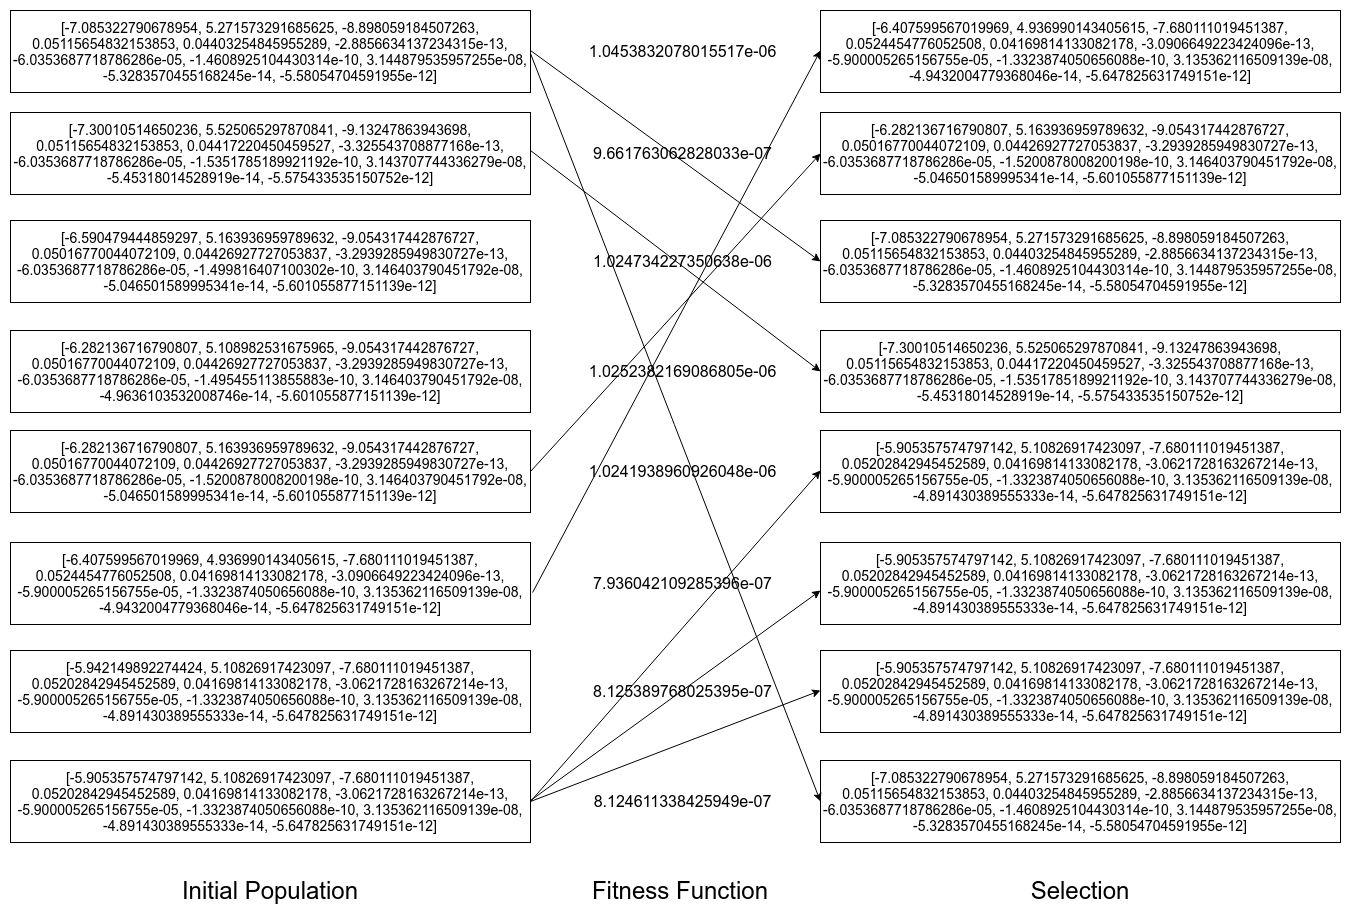
<br><br><br>
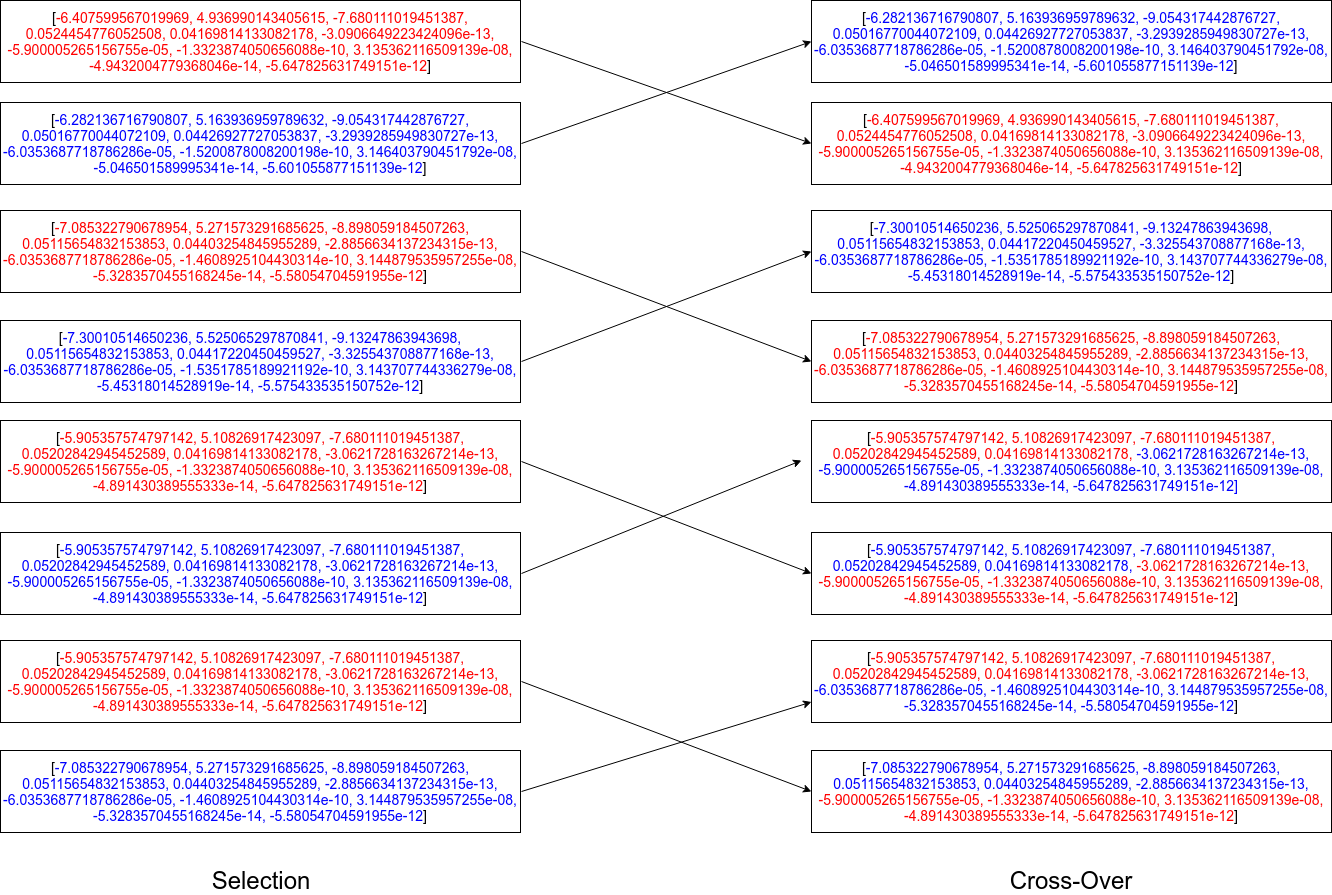
<br><br><br>
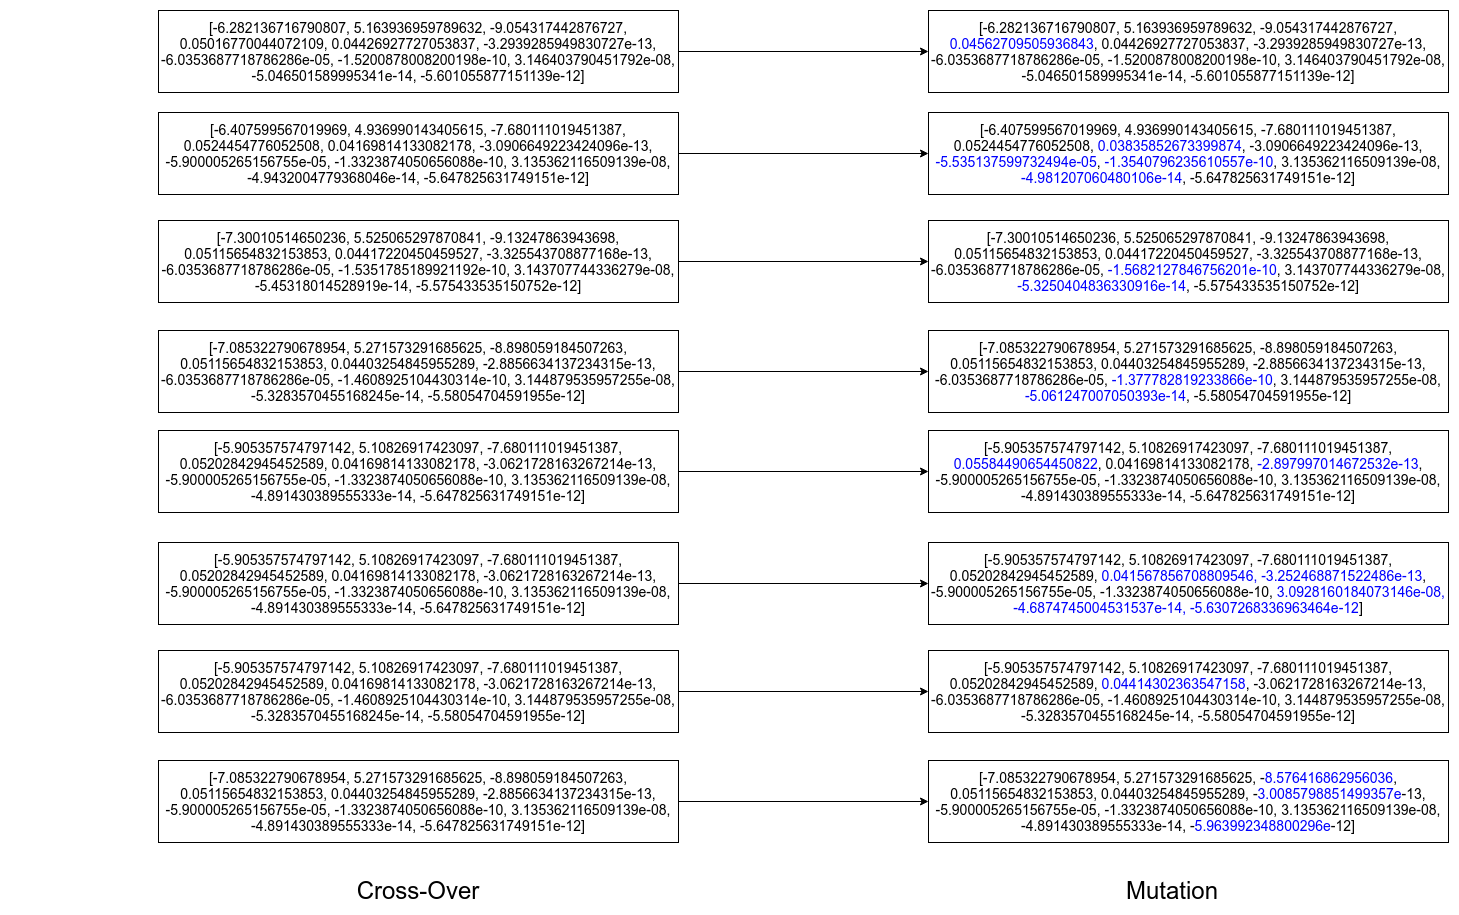


### Iteration 2
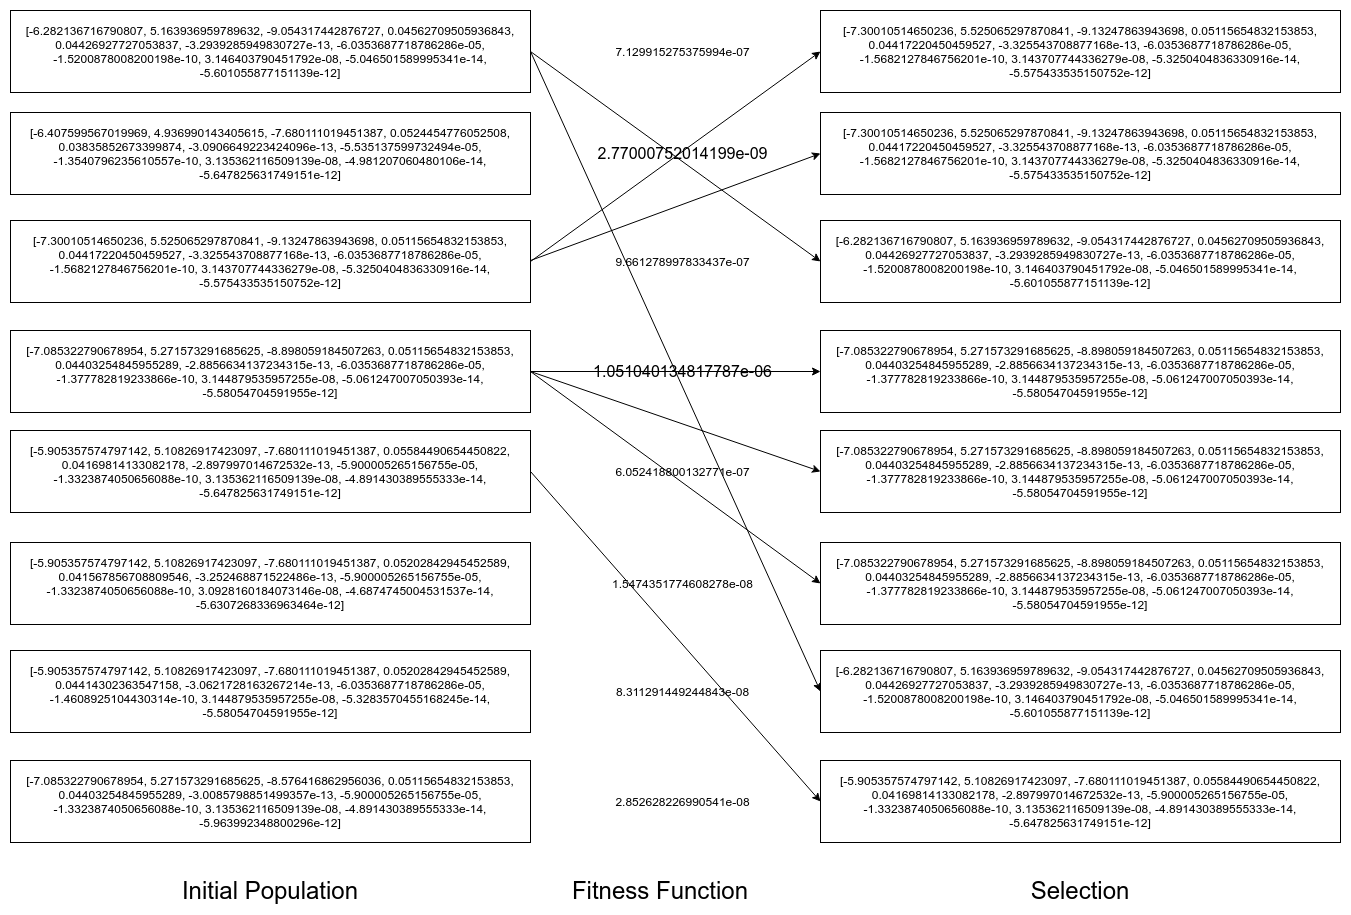
<br><br><br>
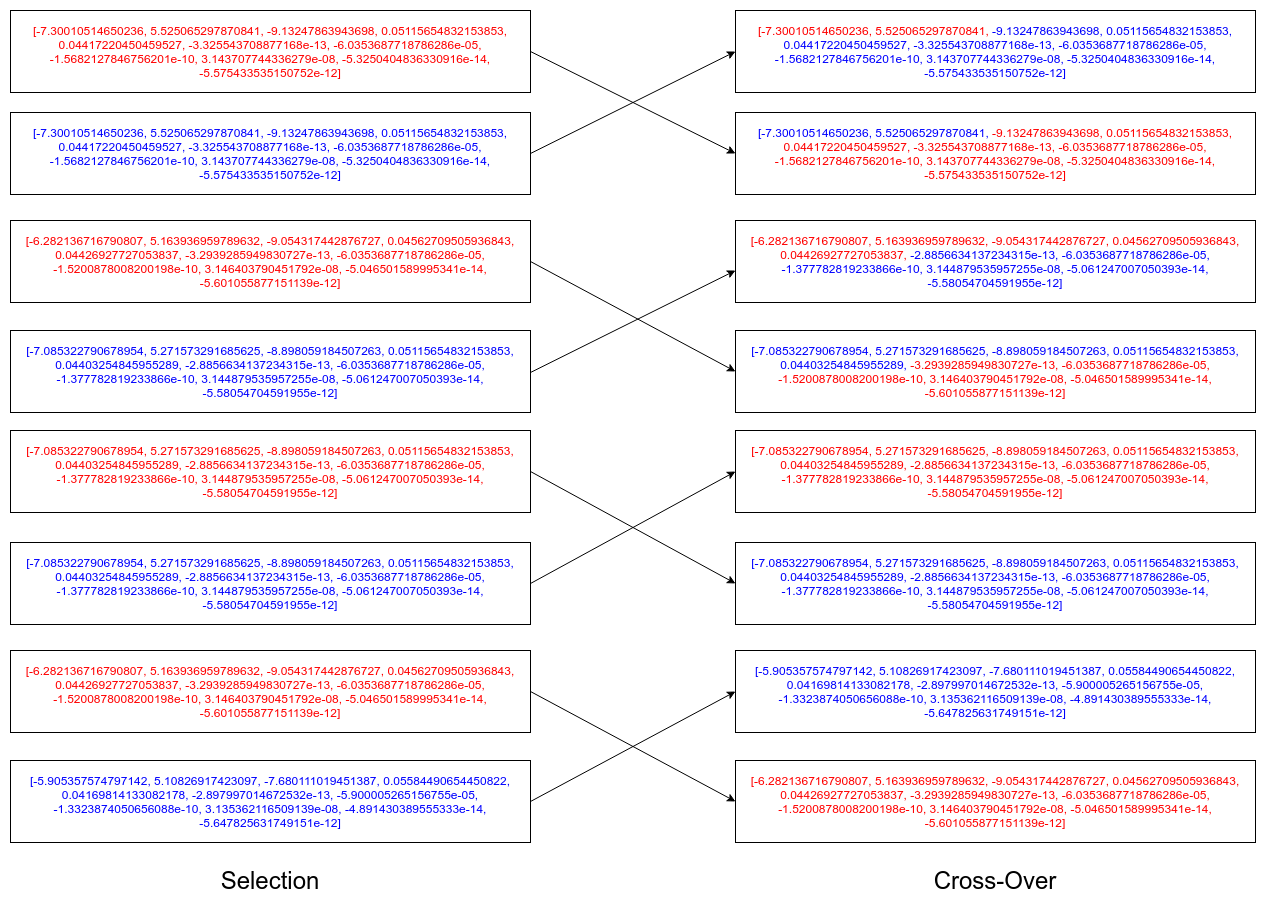
<br><br><br>
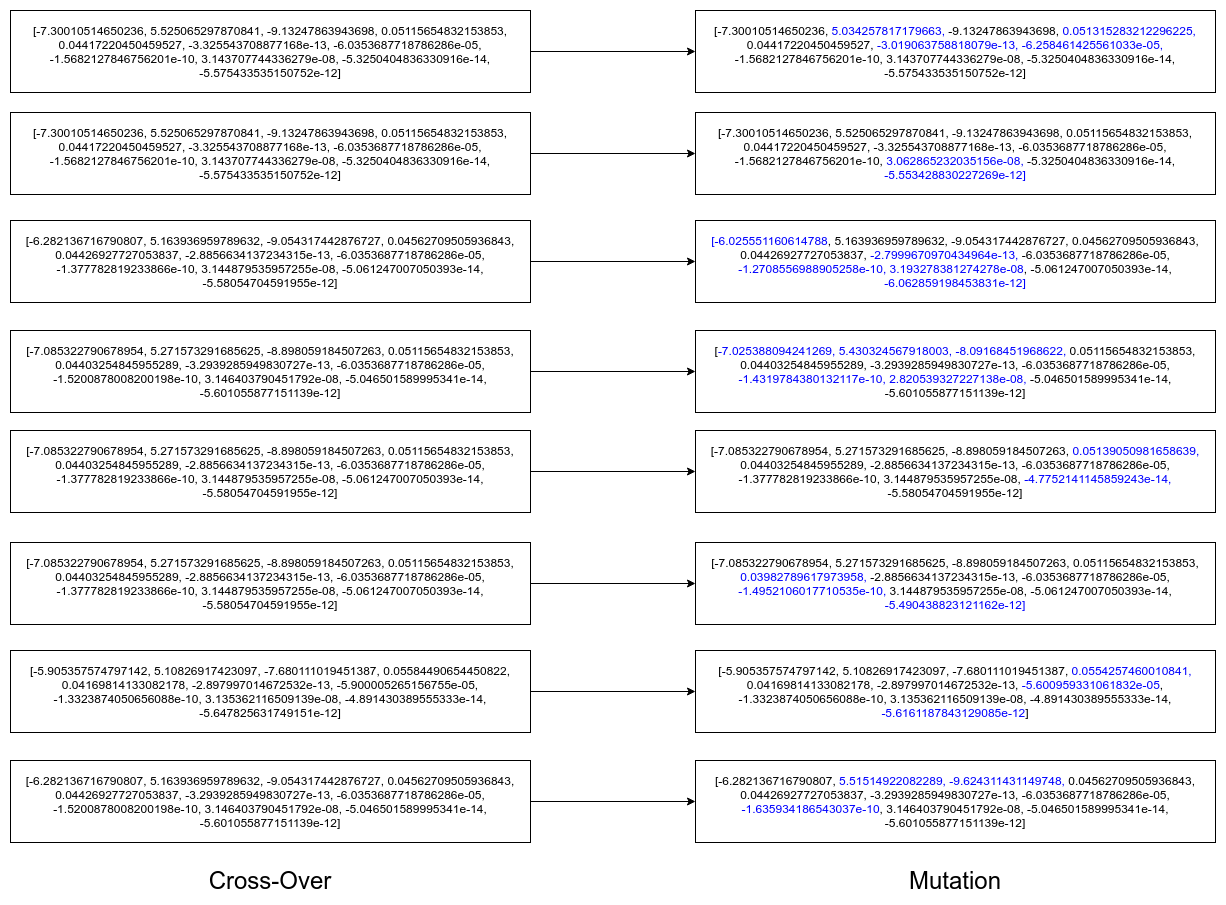

### Iteration 3
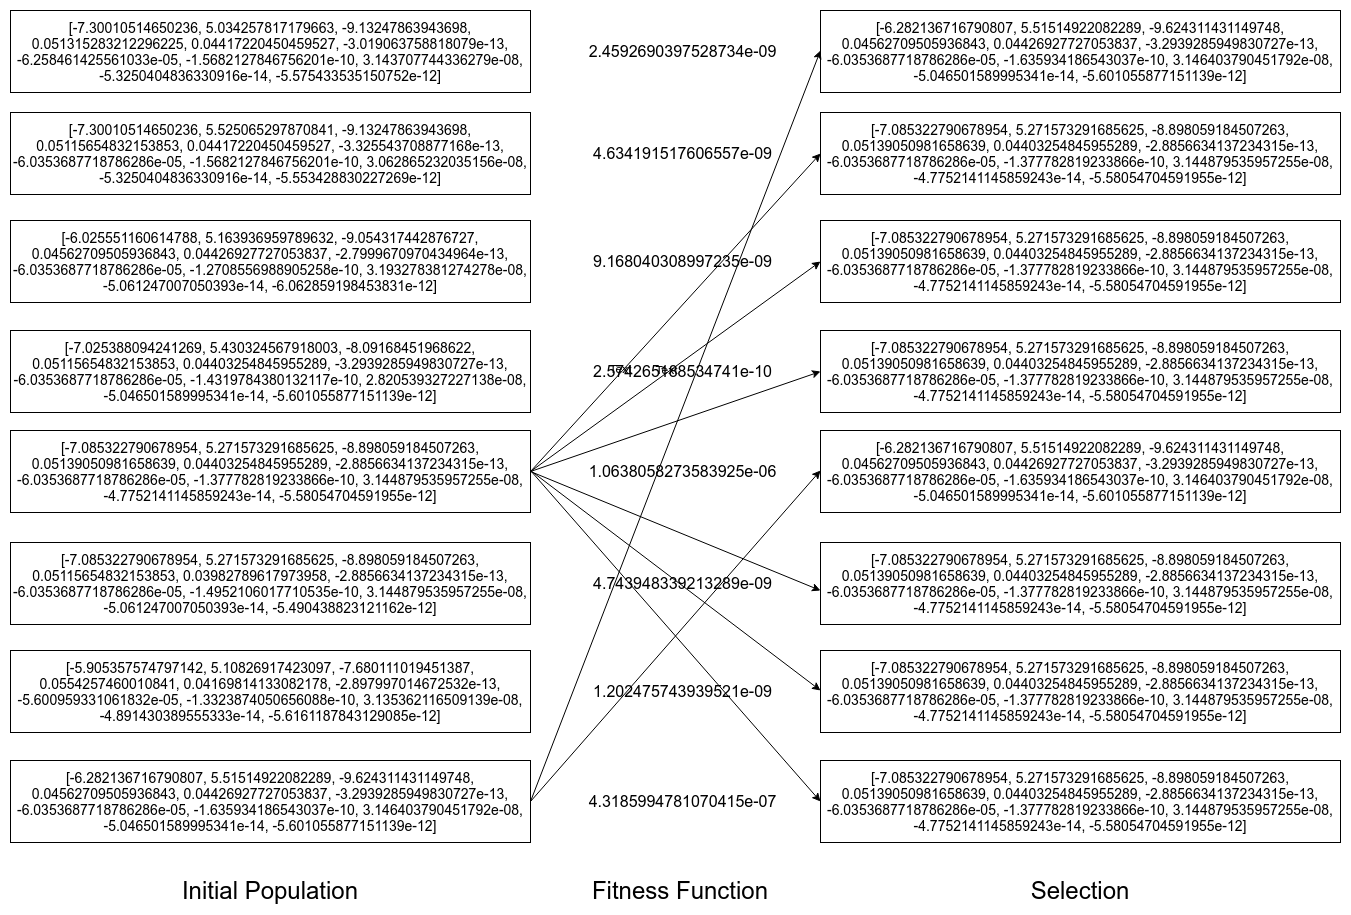
<br><br><br>
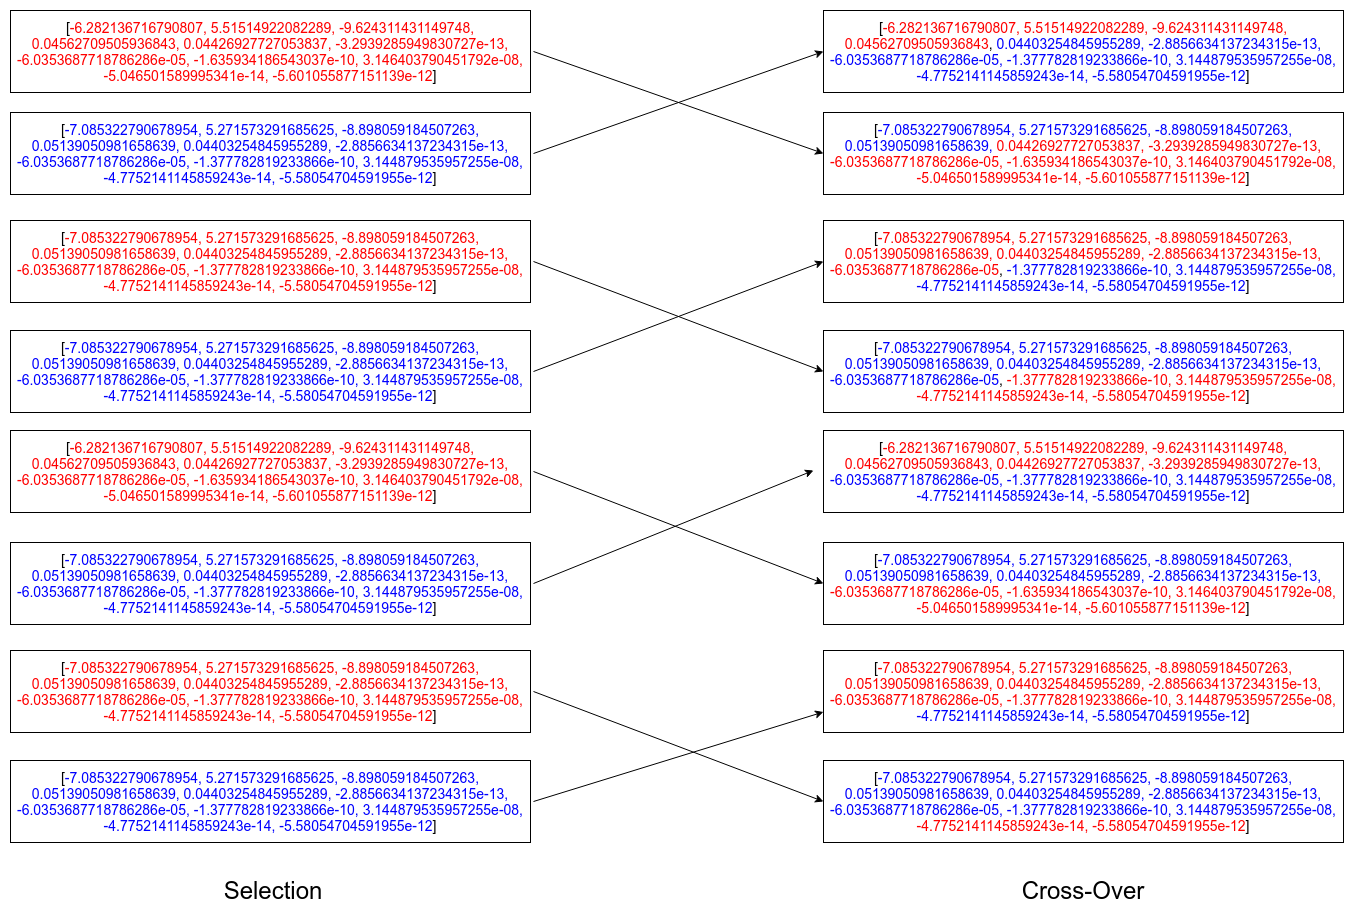
<br><br><br>
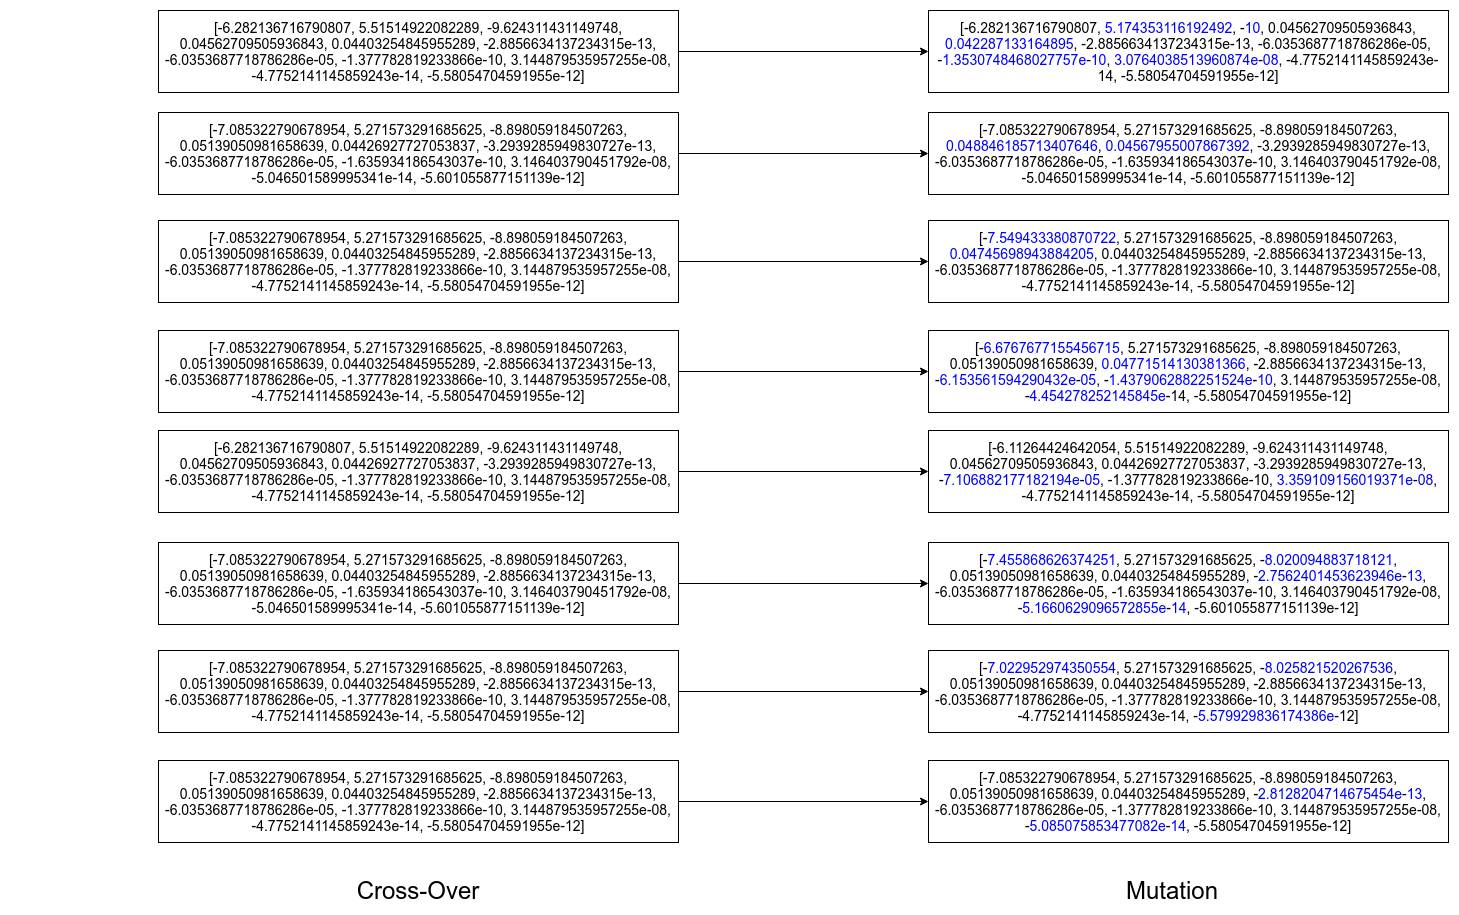

## Trace

Stored in trace.txt file present in the folder

## Some of our vectors (includes some vectors which have overfit and give very less error on training and validation set)

[-4.674148051658985e-13, 8.648472174834275, 3.1771001217149264e-14, 0.038113432916559484, 1.2457899566865488e-13, 1.2661905294587612e-12, -6.616654280725267e-14, 5.140049692343619e-13, -1.0302936466642132e-12, 1.323283403018702e-12, -4.066434650076272e-15]: [202382.86037400895, 202382.6792825716]

[-8.664635954917092, 5.575783957375224, -9.155913549097217, 0.05386099767485844, 0.04403254845955289, -2.810663699658785e-13, -6.0353687718786286e-05, -1.2253792562205487e-10, 3.144879535957255e-08, -4.379709958691899e-14, -5.5659623887667496e-12]: [493400.46223832574, 312759.28747731785]


[-6.867037376349271, 5.245066484133343, -8.840377252763858, 0.05160563957817047, 0.04403254845955289, -3.3930520604418364e-13, -6.0353687718786286e-05, -1.2431613463193698e-10, 3.144879535957255e-08, -4.237448988712987e-14, -5.58054704591955e-12]: [426015.2616280128, 399067.51661741117]


[-9.173547923218994, 5.7433691522011285, -8.968321372242036, 0.04966932879577903, 0.042108000209460886, -3.4901900461313593e-13, -5.8586027995786236e-05, -1.4679333076478706e-10, 3.13511131368777e-08, -4.56722032624001e-14, -5.714728758432666e-12]: [504242.7541159205, 243483.59688776714]


[-3.886844211231476e-13, 9.505009100836133, 4.80118886489963e-14, 0.03607455738069221, 1.1091512504697103e-13, 7.018257854362723e-13, -4.060786221468463e-14, 4.1390269056731094e-13, -1.145713347732145e-12, 1.543761942931371e-12, -3.560625490765323e-15]: [201439.31672921564, 201439.3167834141]

[-1.0243911708919906e-12, 8.51247762272303, -5.835472784567202e-14, 0.045430924415846, 2.315323572538751e-13, 9.260290061423642e-13, 2.016075388308313e-13, 7.967828545287159e-13, -1.022260778150978e-12, 4.0744076620175574e-13, -7.719253852496137e-15]: [243610.23005238594, 243657.43915714038]

The format of the shown vectors was:

vector: [training error, validation error]